In [142]:
import pandas as pd
import numpy as np
import string
import time
import random
import unidecode
import math

import torch
import torch.nn as nn
from torch.autograd import Variable

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [134]:
lines = pd.read_csv("the-office-lines-simplified.csv")
characters = {
    "Michael":1,"Dwight":2,"Jim":3,"Pam":4,"Andy":5,"Kevin":6,"Angela":7,
    "Oscar":8,"Erin":9,"Ryan":10,"Darryl":11,"Phyllis":12,"Kelly":13,"Jan":14,"Toby":15,"Other":16
}

characters_inverted = {}
for c in characters:
    characters_inverted[characters[c]] = c
print characters_inverted

all_characters = string.printable # switch this with words instead of characters
n_characters = len(all_characters)

{1: 'Michael', 2: 'Dwight', 3: 'Jim', 4: 'Pam', 5: 'Andy', 6: 'Kevin', 7: 'Angela', 8: 'Oscar', 9: 'Erin', 10: 'Ryan', 11: 'Darryl', 12: 'Phyllis', 13: 'Kelly', 14: 'Jan', 15: 'Toby', 16: 'Other'}


In [133]:
full_text = ""
for i, line in enumerate(lines['line_text']):
    full_text += characters_inverted[lines['speaker_id'][i]] + ': ' + lines['line_text'][i] + '\n'
    #if i==10: break
words = []

In [135]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [136]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [137]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [138]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

chunk_len = 200

def random_chunk():
    start_index = random.randint(0, len(full_text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return full_text[start_index:end_index]

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

print(random_chunk())

tensor([10, 11, 12, 39, 40, 41])
w. Hey, nice talking to you too. All right take care. [sighs] Michael Scoot. That's funny. He's a good friend.
Dwight: [eating Tootsie Rolls from Angela's candy on her desk] Mmm. Good. Mmm.
Angela: The


In [139]:


def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted



In [146]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print evaluate('Wh', 400) + '\n'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 14s (100 0%) 2.3342]
Whela meantith afond thote no?
Pam: hat thange gmay that thincut and mere mantt fofeon. mouond thael mely man here s.
Osmer: 1-_A9(
POos?? barr in thansy. Thany het thidn.
Pam: Atans thouree thave an So. [foudich wobele to nounele fo ceond cowh. Whol. That abed fon?? The ar me giled thing ast a noele thightet eaf dond whas give feleons sut the that mete on and cound.
Payn: She hond thetinch and orut

 28s (200 0%) 1.9963]
What furs it thut ther have fo mat one, think in't hen thered to gut han and thet I bouts I dond is is to fes mot the hap oond sind of liontight whind lind mand the Oh the cham bort you gon meve mind the min Mazyl go gotis ming a then I in my of bum, that beah ming dove bos gusursinnt me gefontind for go wined sume?  Jim. You ligtell in you hameing hoing anded if baelay Hory dely in you to I batan t

 43s (300 0%) 1.9422]
What's ut to to dot. Yechause.
Other: That to core get to Mientor to kif?
Dwight: You get this. Worker thing thins tuys thing 

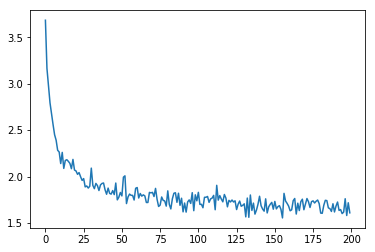

In [147]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [149]:
print evaluate('Andy', 200)

Andy: Yeah.  Michael really the suff]
Michael: Buttle. I do you're why doo?
Michael: No the not anyss. I'm Joung.
Michael: No. I don't want sitches. He's was her.
Darryl: Pelley or now supent freen to you
